# USC CSCI 567 HW3

Author: Thamme Gowda N  
USCID: 2074669439

In [143]:
from __future__ import print_function
import random
import numpy as np
from matplotlib import pyplot as plt
import math

## Bias Variance Trade-of

In [144]:
# Generate random data
def uniform_randoms(start, end, count):
    return [random.uniform(start, end) for _ in range(count)]

def generate_datasets(start, end, count, sets):
    return np.array([uniform_randoms(start, end, count) for _ in range(sets)])

# define f(x) 
def f(x, e=None):
    if e is None:
        e = random.gauss(0.0, math.sqrt(0.1))
    return 2 * x * x + e

def generate_ys(datasets):
    yss = []
    for xs in datasets:
        ys =[f(x) for x in xs]
        yss.append(ys)
    return np.array(yss)


Number of datasets=100, Number of Samples=10, number of samples in testset:100
Function	 Variance		 Bias^2
g1		 0.00000000		 0.55381366
g2		 0.04447961		 0.41991505
g3		 0.11798539		 0.42180300
g4		 0.04600876		 0.09363664
g5		 0.12355812		 0.09612371
g6		 1.98816964		 0.09745515


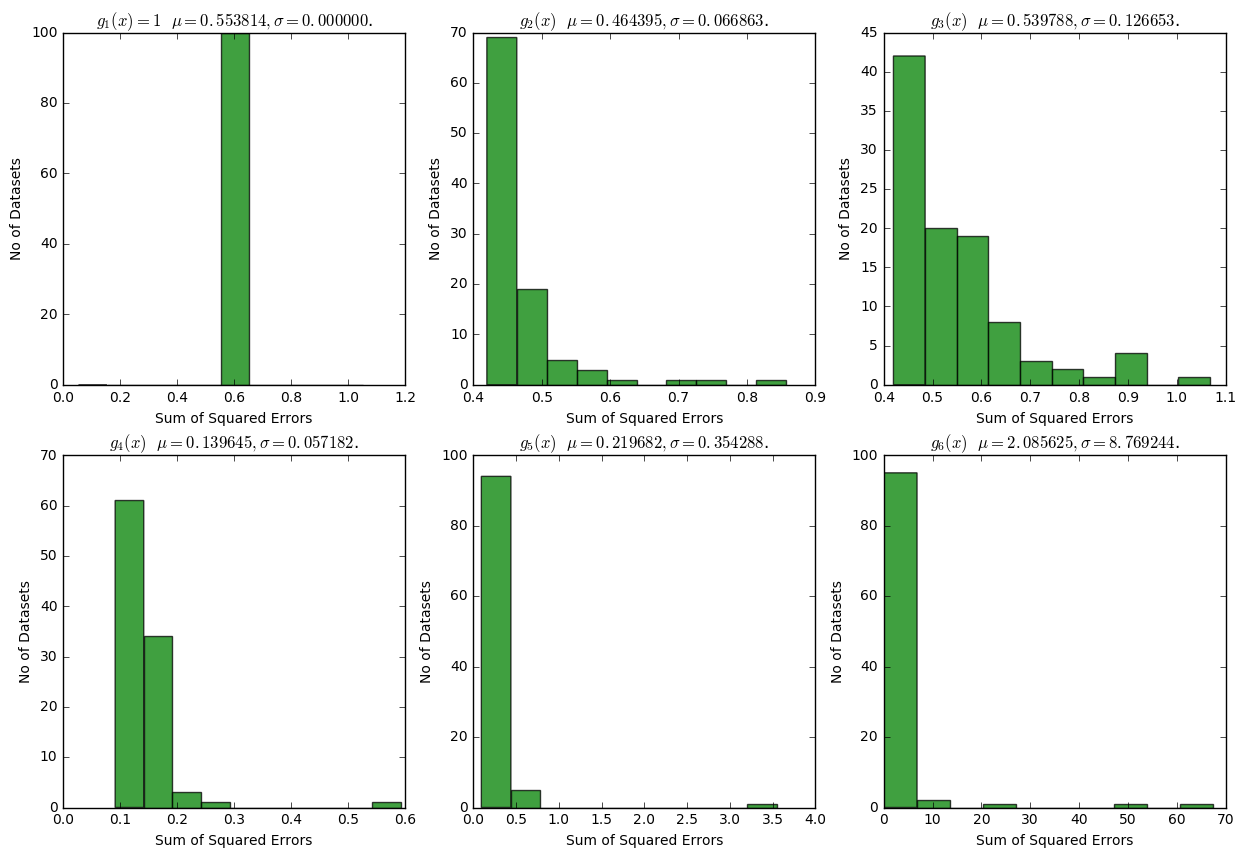

In [160]:
def predict(X, W):
    return np.matmul(X, W)

def MSECost(Y2, Y1):
    return float(np.sum((Y2 - Y1) ** 2) / len(Y2))

def fit_line(X, Y):
    return np.matmul(
        np.matmul(
            np.linalg.pinv(np.matmul(X.transpose(), X)),
            X.transpose()),
        Y)

class LinearRegression(object):
    
    def __init__(self, X, Y):
        self.means = X.mean(axis=0)
        self.stds = X.std(axis=0)
        X = self.normalize(X)
        self.W = self._find_W(X, Y)
        #print(X.shape, self.W.shape, self.means, self.stds)

    def _find_W(self, X, Y):
        return fit_line(X, Y)

    def normalize(self, X, standardize=False):
        if standardize:
            X = (X - self.means) / self.stds
        # Bias is added as a weight to simplify the calculations
        X = np.insert(X, 0, 1, axis=1)
        return X
    
    def predict(self, X):        
        X = self.normalize(X)
        return np.matmul(X, self.W)
    
    def __repr__(self):
        return "W:%s, means:%s, Stds:%s" % (self.W, self.means, self.stds)

def phi(X, high, low=1):
    phi_X = np.zeros(shape=(len(X), 0))
    for power in range(low, high+1):
        phi_X = np.insert(phi_X, phi_X.shape[1], X ** power, axis=1)
    return phi_X

highest_poly_deg = 4
def report_bias_variance(n, num_ds, m=1000):
    print("Number of datasets=%d, Number of Samples=%d, number of samples in testset:%d" % (num_ds, n, m))
    print("Function\t Variance\t\t Bias^2")
    datasets = generate_datasets(-1, 1, n, num_ds)
    test_set = generate_datasets(-1, 1, m, 1)[0]
    yss = generate_ys(datasets)
    test_ys = generate_ys([test_set])[0]
    
    plt.figure(1, figsize=(15, 10))
    # G1 is a constant output function, no learning required, thus no regression
    predY = np.array([1.0 for _ in range(m)])
    cost = MSECost(test_ys, predY)
    costs = np.array([cost for _ in range(num_ds)]) # all of them have same cost
    variance = 0 #
    bias_2 = np.sum((predY - test_ys)**2) / m
    print("g1\t\t %.8f\t\t %.8f" % (variance, bias_2))
    plt.subplot(2, 3, 1)
    plt.hist(costs, 10, facecolor='green', alpha=0.75)
    plt.xlabel('Sum of Squared Errors')
    plt.ylabel('No of Datasets')
    plt.title(r'$g_%d(x)=1$  $\mu=%f, \sigma=%f$.' % (1, costs.mean(), costs.std()))
    
    #print("Xs:",datasets)
    for j in range(highest_poly_deg + 1): # highest power of X
        models = [LinearRegression(phi(datasets[i], j), yss[i]) for i in range(num_ds)]
        phi_test_set = phi(test_set, j)
        preds = np.zeros(shape=(num_ds, m))        
        costs = np.zeros(num_ds)
        for row in range(num_ds):
            pred_y = models[row].predict(phi_test_set)
            costs[row] = MSECost(pred_y, test_ys)
            for col in range(m):
                preds[row,col] = pred_y[col]

        avgx = preds.mean(axis=0) # averaging over datasets, axis=0 is data_sets
        spread = np.zeros(shape=(num_ds, m))
        for col in range(m):
            for row in range(num_ds):
                spread[row, col] = abs(preds[row,col] - avgx[col])
        variance = np.sum(spread ** 2) / (float(num_ds * m))
                
        bias_2 = 0.
        for col in range(m):
            bias_2 += (avgx[col] - test_ys[col]) ** 2
        bias_2 = bias_2 / m
        
        print("%s\t\t %.8f\t\t %.8f" % ("g%d" % (j+2), variance, bias_2))

        #print(costs)
        plt.subplot(2, 3, 2 + j)
        plt.hist(costs, 10, facecolor='green', alpha=0.75)
        plt.xlabel('Sum of Squared Errors')
        plt.ylabel('No of Datasets')
        plt.title(r'$g_%d(x)$  $\mu=%f, \sigma=%f$.' % (j + 2, costs.mean(), costs.std()))

    plt.show()
report_bias_variance(n=10, num_ds=100, m=100)

Number of datasets=100, Number of Samples=100, number of samples in testset:100
Function	 Variance		 Bias^2
g1		 0.00000000		 0.58901086
g2		 0.00464569		 0.45072357
g3		 0.01270188		 0.45209526
g4		 0.00269852		 0.10926987
g5		 0.00366258		 0.10922298
g6		 0.00511599		 0.10889857


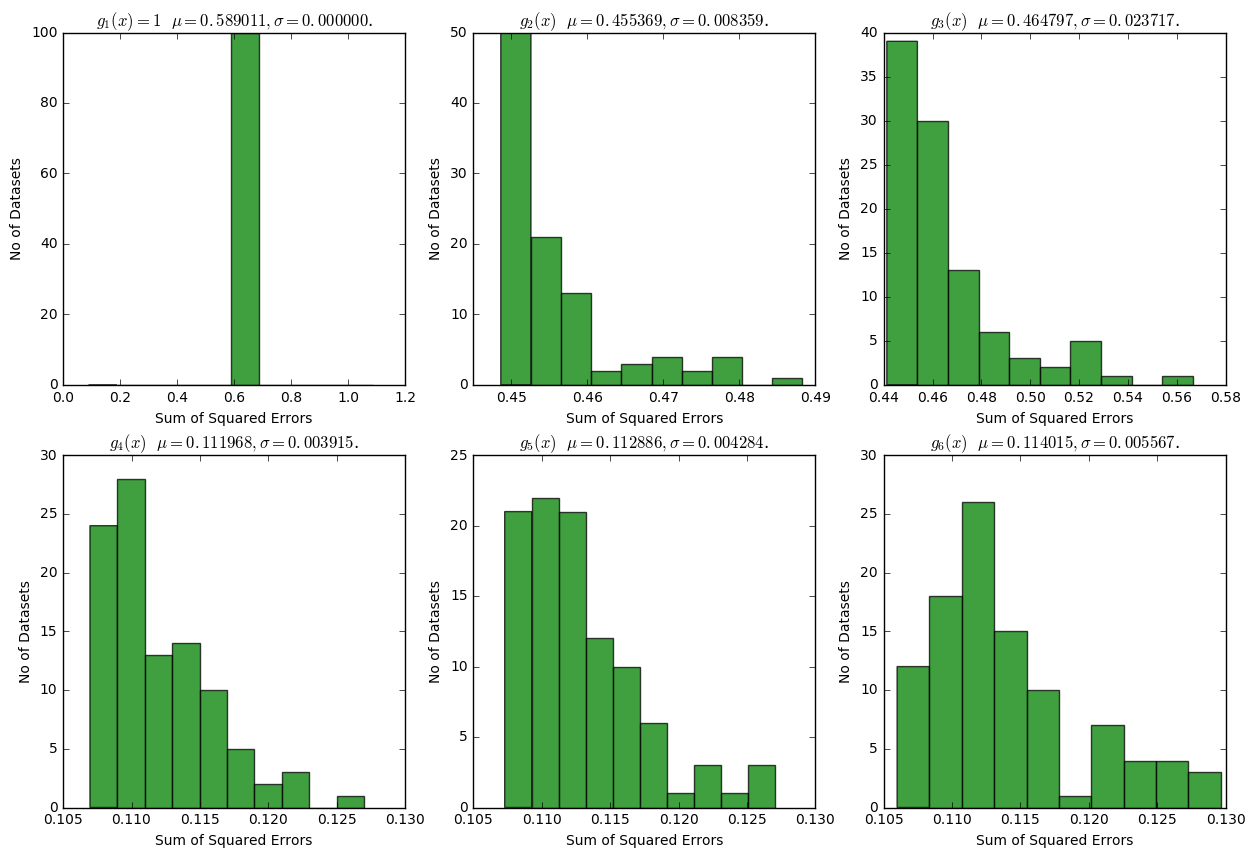

In [161]:
report_bias_variance(n=100, num_ds=100, m=100)

## Ridge regression

In [168]:
def fit_line_with_bias(X, Y, lambd):
    # (X'X + \lambda I)^{-1} X'Y
    res = np.matmul(X.transpose(), X)
    bias = np.multiply(np.eye(res.shape[0]), lambd)
    res = res + bias
    res = np.linalg.pinv(res)
    res = np.matmul(res, X.transpose())
    res = np.matmul(res, np.array(Y))
    return res

class RidgeRegression(LinearRegression):
    def __init__(self, X, Y, lambd):
        self.lambd = lambd
        super(RidgeRegression, self).__init__(X, Y)

    def _find_W(self, X, Y):
        return fit_line_with_bias(X, Y, self.lambd)

def report_lambd_effect(n, num_ds):
    Xs = generate_datasets(-1, 1, n, num_ds)
    Ys = generate_ys(Xs)
    m = 100 # samples for test data

    test_set = generate_datasets(-1, 1, m, 1)[0]
    test_ys = generate_ys([test_set])[0]
    lambds = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]
    j = 2 # degree of polynomial
    print("Lambda\t Variance\t Bias")
    for lambd in lambds:
        models = [RidgeRegression(phi(Xs[i], j), Ys[i], lambd) for i in range(num_ds)]
        phi_test_set = phi(test_set, j)
        preds = np.zeros(shape=(num_ds, m))
        for row in range(num_ds):
            pred_y = models[row].predict(phi_test_set)
            for col in range(m):
                preds[row,col] = pred_y[col]

        avgx = preds.mean(axis=0) # averaging over datasets, axis=0 is data_sets
        spread = np.zeros(shape=(num_ds, m))
        for col in range(m):
            for row in range(num_ds):
                spread[row, col] = abs(preds[row,col] - avgx[col])
        variance = np.sum(spread ** 2) / (float(num_ds * m))

        bias_2 = 0.
        for col in range(m):
            bias_2 += (avgx[col] - test_ys[col])**2
        bias_2 = bias_2 / (m)
        print("%g\t %g\t %g" % (lambd, variance, bias_2))

report_lambd_effect(100, 100)

Lambda	 Variance	 Bias
0.001	 0.00291082	 0.110499
0.003	 0.00290983	 0.110496
0.01	 0.00290636	 0.110483
0.03	 0.00289664	 0.110451
0.1	 0.00286453	 0.110368
0.3	 0.00278789	 0.110376
1	 0.00265098	 0.11267


# Support Vector Machines (SVM)

In [194]:
from scipy import io
test_file = '../data/phishing-test.mat'
train_file = '../data/phishing-train.mat'

def transform_features(X):
    newX = np.zeros(shape=(X.shape[0], 0))
    for i in range(X.shape[1]):
        vals = set(X[:, i])
        if len(vals) == 3: # break into three boolean cols
            for val in vals:
                new_col = map(lambda a: int(a == val), X[:, i])
                newX = np.insert(newX, newX.shape[1], new_col, axis=1)
        elif -1 in vals:
            new_col = map(lambda a: int(a > 0), X[:, i]) # replace -1 with 0
            newX = np.insert(newX, newX.shape[1], new_col, axis=1)
        else:
            newX = np.insert(newX, newX.shape[1], X[:, i], axis=1)
    return newX

def load_data(fn):
    mat = scipy.io.loadmat(train_file)
    Y = mat['label']
    X = mat['features']
    return transform_features(X), Y.flatten()

def store_svm_vectors(X, Y, file_name):
    assert(len(X) == len(Y))
    with open(file_name, 'wb') as f:
        for i in range(len(Y)):
            f.write("%d " % Y[i]) # label
            pairs = map(lambda t: "%d:%d"% t, enumerate(X[i]))
            f.write(" ".join(pairs)) # attributes
            f.write("\n")

X, Y = load_data(train_file)
testX, testY = load_data(test_file)

store_svm_vectors(X, Y, 'train.data')
store_svm_vectors(testX, testY, 'test.data')

In [228]:
%%script bash
pow(){
    python -c "from sys import argv as a; print(pow(int(a[1]), int(a[2])))" $1 $2
}

millis(){  python -c "import time; print(int(time.time()*1000))"; }

linear_kernel(){
    echo "Linear Kernel"
    START=$(millis)
    counter=0
    for i in $(seq -6 2); do
        c=$(pow 4 $i)
        echo "C=$c"
        svm-train -t 0 -c $c -v 3 train.data | grep "Accuracy"
        ((counter++))
    done;
    END=$(millis)
    DIFF=$(echo "$END - $START" | bc)
    echo "Total time taken:"$DIFF ", $counter experiments"
    echo "Average taken :" $(echo "$DIFF / $counter" | bc) "ms"
}

poly_kernel(){
    echo "Polynomial Kernel"
    START=$(millis)
    counter=0
    for i in $(seq -3 7); do
        c=$(pow 4 $i)
        for deg in $(seq 1 3); do
            echo "C=$c, degree=$deg"
            svm-train -t 1 -c $c -d $deg -v 3 train.data | grep "Accuracy"
            ((counter++))
        done;
    done;
    END=$(millis)
    DIFF=$(echo "$END - $START" | bc)
    echo "Total time taken:"$DIFF ", $counter experiments"
    echo "Average taken :" $(echo "$DIFF / $counter" | bc) "ms"
}
RBF_kernel(){
    echo "RBF Kernel"
    START=$(millis)
    counter=0
    for i in $(seq -3 7); do
        c=$(pow 4 $i)
        for j in $(seq -7 -1); do
            gamma=$(pow 4 $j)
            echo "C=$c, gamma=$gamma"
            svm-train -t 2 -c $c -g $gamma -v 3 train.data | grep "Accuracy"
            ((counter++))
        done;
    done;
    END=$(millis)
    DIFF=$(echo "$END - $START" | bc)
    echo "Total time taken:"$DIFF ", $counter experiments"
    echo "Average taken :" $(echo "$DIFF / $counter" | bc) "ms"
}

linear_kernel
poly_kernel
RBF_kernel

Linear Kernel
C=0.000244140625
Cross Validation Accuracy = 55.75%
C=0.0009765625
Cross Validation Accuracy = 88.2%
C=0.00390625
Cross Validation Accuracy = 91.35%
C=0.015625
Cross Validation Accuracy = 92.75%
C=0.0625
Cross Validation Accuracy = 93.9%
C=0.25
Cross Validation Accuracy = 94.6%
C=1
Cross Validation Accuracy = 94.65%
C=4
Cross Validation Accuracy = 94.5%
C=16
Cross Validation Accuracy = 94.4%
Total time taken:2823 , 9 experiments
Average taken : 313 ms
Polynomial Kernel
C=0.015625, degree=1
Cross Validation Accuracy = 55.75%
C=0.015625, degree=2
Cross Validation Accuracy = 55.75%
C=0.015625, degree=3
Cross Validation Accuracy = 55.75%
C=0.0625, degree=1
Cross Validation Accuracy = 90.35%
C=0.0625, degree=2
Cross Validation Accuracy = 89%
C=0.0625, degree=3
Cross Validation Accuracy = 74.9%
C=0.25, degree=1
Cross Validation Accuracy = 91.15%
C=0.25, degree=2
Cross Validation Accuracy = 92.15%
C=0.25, degree=3
Cross Validation Accuracy = 92.05%
C=1, degree=1
Cross Validation

In [128]:
import subprocess
from time import time
import re

LINEAR = 0; POLY = 1; RBF = 2 #kernels
train_data = "train.data"
test_data = "test.data"

def svm_train(kernel, data, verbose=False, model_file='', **args):
    arg_str = " ".join(map(lambda p: '-%s %s' % (str(p[0]), str(p[1])), args.items()))
    cmd = "svm-train -t %d %s %s %s" % (kernel, arg_str, data, model_file)
    if verbose:
        print(cmd)
    t = time()
    res = subprocess.check_output(cmd.split()).split('\n')
    if 'v' in args:
        res = filter(lambda line: 'Accuracy' in line, res)
        return float(re.search("=\s*(\d*(\.\d*)?)%$", res[0].strip()).group(1)), ((time() - t)/ args['v'])
    return None

def svm_predict(data, model, output):
    cmd = "svm-predict %s %s %s" % (data, model, output)
    return subprocess.check_output(cmd.split()).strip()

In [130]:

best = float('-inf')
best_params = None

print("LINEAR KERNEL\n#\t\tC\tAvgTime\t\tAccuracy%")
Cs = map(lambda x: pow(4, x), range(-6, 3))
for i,C in enumerate(Cs):
    res, t = svm_train(POLY, train_data, v=3, c=C)
    print("%d\t %11g\t%f\t%.2f"%(i+1, C, t, res))
    if res > best:
        best = res
        best_params = "Linear Kernel, C=%f" % C

print("POLYNOMIAL KERNEL\n#\t\t C\tDegree\tAvgTime\t\tAccuracy%")
Cs = map(lambda x: pow(4, x), range(-3, 8))
degs = [1,2,3]
ctr = 0
for C in Cs:
    for deg in degs:
        ctr += 1
        res, t = svm_train(POLY, train_data, v=3, c=C, d=deg)
        print("%d\t %11g\t%d\t%f\t%.2f"%(ctr, C, deg, t, res))
        if res > best:
            best = res
            best_params = "Plynomial Kernel, C=%f, degree=%d" % (C, deg)


print("RBF KERNEL\n#\t\t C\tGamma\t\tAvgTime\t\tAccuracy%")
Cs = map(lambda x: pow(4, x), range(-3, 8))
gammas = map(lambda x: pow(4, x), range(-7, 0))
ctr = 0
for C in Cs:
    for gamma in gammas:
        ctr += 1
        res, t = svm_train(RBF, train_data, v=3, c=C, g=gamma)
        print("%d\t %11g\t%f\t%f\t%.2f"%(ctr, C, gamma, t, res))
        if res > best:
            best = res
            best_params = "RBF Kernel, C=%f, gamma=%f" % (C, gamma)

print("## BEST RESULTS")
print(best_params)
print("Best Accuracy: %.2f" % best)

LINEAR KERNEL
#		C	AvgTime		Accuracy%
1	 0.000244141	0.213693	55.75
2	 0.000976562	0.201526	55.75
3	  0.00390625	0.197195	55.75
4	    0.015625	0.190556	55.75
5	      0.0625	0.196112	74.90
6	        0.25	0.147726	92.05
7	           1	0.100852	92.80
8	           4	0.065552	95.10
9	          16	0.053958	96.40
POLYNOMIAL KERNEL
#		 C	Degree	AvgTime		Accuracy%
1	    0.015625	1	0.193540	55.75
2	    0.015625	2	0.201199	55.75
3	    0.015625	3	0.200625	55.75
4	      0.0625	1	0.174386	90.35
5	      0.0625	2	0.198155	89.00
6	      0.0625	3	0.198131	74.90
7	        0.25	1	0.103184	91.15
8	        0.25	2	0.116746	92.15
9	        0.25	3	0.147319	92.05
10	           1	1	0.073813	92.85
11	           1	2	0.079659	93.30
12	           1	3	0.100888	92.80
13	           4	1	0.056519	94.35
14	           4	2	0.063589	94.90
15	           4	3	0.067277	95.10
16	          16	1	0.054508	94.30
17	          16	2	0.057410	95.95
18	          16	3	0.055024	96.40
19	          64	1	0.056362	94.15
20	          64	2	0.0508

In [129]:
from sklearn.svm import SVC

#The highest was RBF 
#Cross Validation Accuracy = 97.2%
C=256; gamma=0.015625

model = "best_model.dat" 
svm_train(RBF, train_data, model_file=model, c=C, g=gamma)
print("Test Accuracy::")
print(svm_predict(test_data, model, "/dev/null"))


Test Accuracy::
Accuracy = 98.5% (1970/2000) (classification)
